<a href="https://colab.research.google.com/github/ajeancharles/DCGAN_Exploration/blob/main/mnist_dcgan_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [37]:
%pip install -q imageio

In [38]:
import glob, imageio
import matplotlib.pyplot as plt
import numpy as np
import os, PIL
import time
from tensorflow.keras import layers
from IPython import display

In [39]:
(train_image, train_label), (_,_) = tf.keras.datasets.mnist.load_data()

In [40]:
train_image.shape, train_image[0].shape

((60000, 28, 28), (28, 28))

In [41]:
train_image.shape[0]

60000

In [42]:
train_image = train_image.reshape(train_image.shape[0],28,28,1).astype('float32')


In [43]:
train_image.shape, train_image[0].shape

((60000, 28, 28, 1), (28, 28, 1))

In [44]:
train_image = (train_image - 127.5)/127.5

In [45]:
BUFFER_SIZE = 5000
BATCH_SIZE = 256

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [47]:
def make_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256) 

  model.add(layers.Conv2DTranspose(128,(5,5),(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(64,(5,5),(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(1,(5,5),(2,2),padding='same',use_bias=False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model




In [48]:
noise = tf.random.normal([1,100])
print(f"element shape :{noise[0].shape}")

element shape :(100,)


In [49]:
generator = make_generator_model()


In [50]:
gen_imj = generator(noise, training= False)

In [51]:
gen_imj[0,:,:,0].shape

TensorShape([28, 28])

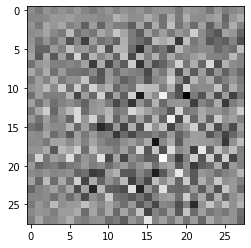

In [52]:
plt.imshow(gen_imj[0,:,:,0] , cmap='gray');

In [53]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

 
  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))


  return model



In [54]:
discriminator = make_discriminator_model()
discriminator(gen_imj, training= False).numpy()[0][0]

-0.00027456775

In [55]:
lossfn_bincross =  tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [56]:
def discriminator_loss(real_output, fake_output):

  real_loss = lossfn_bincross(tf.ones_like(real_output), real_output)
  fake_loss = lossfn_bincross(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss

In [57]:
def generator_loss(fake_output):

  total_loss = lossfn_bincross(tf.ones_like(fake_output), fake_output)
  return total_loss

In [58]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')

In [60]:
checkpoint_prefix

'./training_checkpoints/ckpt'

In [61]:
check_point = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator )

In [62]:
os.getcwd()

'/content'

In [63]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [64]:
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [65]:
seed.numpy().shape

(16, 100)

In [66]:
def train_step(images):

  noise = tf.random.normal([BUFFER_SIZE,noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))



In [67]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] , cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [68]:
def train(dataset, epochs):

  for epoch in range(epochs):

    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)

    generate_and_save_images(model=generator, epoch=(epoch+1), test_input=seed)

    if (epochs+1) % 15 == 0 :
      check_point.save(file_prefix=checkpoint_prefix)

    print(f"time for epoch:{epoch+1}  in min: {(time.time()-start)/60}")

  display.clear_output(wait=True)
  generate_and_save_images(model=generator, epoch=epochs, test_input=seed)


  

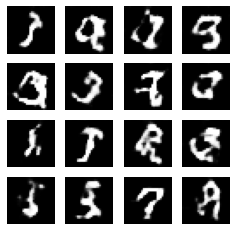

time for epoch: 25 in sec: 123.61862683296204


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restor(tf.train.latest_checkpoint(checkpoint_dir))

/content/image_at_epoch0001.png